## Random

In [2]:
!pip install pandas tqdm scipy matplotlib torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 7.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.6/199.6 KB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 7.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 12.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 24.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 16.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 10.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━

In [5]:
pip install omegaconf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 2.4 MB/s eta 0:00:00
  Using cached antlr4_python3_runtime-4.9.3-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [2]:
%autreload 2

UsageError: Line magic function `%autreload` not found.


In [3]:
import torch

ckpt_path = "/root/.boltz/boltz2_conf.ckpt"

checkpoint = torch.load(ckpt_path, map_location="cpu", weights_only=False)

print("Top-level keys:")
print(checkpoint.keys())

# Explore model state dict keys
print("\nState dict keys (truncated):")
for k in list(checkpoint['state_dict'].keys())[:20]:  # Show first 20 keys
    print(k)

# If hyperparameters were saved
if 'hyper_parameters' in checkpoint:
    print("\nHyperparameters:")
    for k, v in checkpoint['hyper_parameters'].items():
        print(f"{k}: {v}")


Top-level keys:
dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])

State dict keys (truncated):
input_embedder.atom_encoder.embed_atom_features.weight
input_embedder.atom_encoder.embed_atom_features.bias
input_embedder.atom_encoder.embed_atompair_ref_pos.weight
input_embedder.atom_encoder.embed_atompair_ref_dist.weight
input_embedder.atom_encoder.embed_atompair_mask.weight
input_embedder.atom_encoder.c_to_p_trans_k.1.weight
input_embedder.atom_encoder.c_to_p_trans_q.1.weight
input_embedder.atom_encoder.p_mlp.1.weight
input_embedder.atom_encoder.p_mlp.3.weight
input_embedder.atom_encoder.p_mlp.5.weight
input_embedder.atom_enc_proj_z.0.weight
input_embedder.atom_enc_proj_z.0.bias
input_embedder.atom_enc_proj_z.1.weight
input_embedder.atom_attention_encoder.atom_encoder.diffusion_transformer.layers.0.adaln.s_norm.weight
input_embedder.atom_attention_encoder.atom_enco

In [4]:
import sys
sys.path.append("/workspace/gfp_function_prediction")
sys.path.append("/workspace/gfp_function_prediction/boltz")

In [6]:
import sys
import os

# Add the parent directory to sys.path to import boltz
sys.path.append(os.path.join(os.getcwd(), '..'))

try:
    from src.boltz.model.models.boltz2 import Boltz2
    print("✅ Successfully imported Boltz2!")
except ImportError as e:
    print(f"❌ Failed to import Boltz2: {e}")
    print(f"Current sys.path: {sys.path}")

✅ Successfully imported Boltz2!


In [1]:
from pathlib import Path
from dataclasses import asdict, dataclass

In [9]:
from boltz.main import BoltzSteeringParams, Boltz2DiffusionParams, PairformerArgsV2, MSAModuleArgs
from boltz.model.models.boltz2 import Boltz2

In [17]:
from collections import defaultdict

class PairformerHookCollector:
    def __init__(self):
        self.hidden_reps = defaultdict(list)
        self.hooks = []

    def register_hooks(self, model):
        pairformer = (
            model.pairformer_module._orig_mod
            if getattr(model, "is_pairformer_compiled", False)
            else model.pairformer_module
        )

        def hook_fn(module, inputs, outputs):
            try:
                s, z = outputs
                self.hidden_reps["s"].append(s.detach().cpu())
                self.hidden_reps["z"].append(z.detach().cpu())
                print(f"[HOOK FIRED] s: {s.shape}, z: {z.shape}")
            except Exception as e:
                print(f"[HOOK ERROR] {e}")

        self.hooks.append(pairformer.register_forward_hook(hook_fn))

    def get(self):
        return dict(self.hidden_reps)

    def clear(self):
        self.hidden_reps.clear()

    def remove(self):
        for h in self.hooks:
            h.remove()


## Analysis Effective Strain 

Possible sanity check is to check that the files of these mutations are concording with the extracted one here for the analyssi

In [12]:
import numpy as np
import pandas as pd
import os 
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List, Tuple, Optional

In [2]:
main_dir = Path("/n/home06/tbush/gfp_function_prediction/data/outputs/chunks_20250923_120550")
tsv_path = Path("/n/home06/tbush/gfp_function_prediction/data/raw_data/amino_acid_genotypes_to_brightness.tsv")

In [3]:
import re

def extract_seq_numbers(file_ids):
    """
    Extract integer sequence numbers from file_ids of the form
    '.../seq_00017.fasta_prot_pipeline_model_0_output'.

    Args:
        file_ids (list[str]): list of file identifier strings

    Returns:
        list[int]: extracted sequence numbers
    """
    seq_nums = []
    for fid in file_ids:
        match = re.search(r"seq_(\d+)", fid)
        if not match:
            raise ValueError(f"Could not find 'seq_' pattern in: {fid}")
        seq_nums.append(int(match.group(1)))
    return seq_nums

In [13]:
def load_strain_numpy_recursive(
    root_dir: Path,
    columns: List[str] = None,
) -> Tuple[np.ndarray, List[str], List[Path], List[str]]:
    """
    Recursively loads specified per-residue columns from every .csv under root_dir,
    returning a single stacked array.

    Parameters
    ----------
    root_dir : Path
        Root directory to search for CSV files.
    columns : list[str], optional
        Per-residue columns to extract, in desired order. Defaults to:
        ['mut_dist','strain','shear','non_affine','ldd','lddt','rmsd_per_residue','rmsd_overall']

    Returns
    -------
    features : np.ndarray
        Array of shape (n_files, n_residues, n_features) where n_features == len(columns).
    file_ids : list[str]
        Relative paths without '.csv' (e.g., 'subdir/sample1'), same order as the first axis.
    files : list[Path]
        Absolute Paths to the files, same order as the first axis.
    legend : list[str]
        The column order used in the last dimension (exactly `columns`).
    """
    if columns is None:
        columns = [
            'mut_dist', 'strain', 'shear', 'non_affine',
            'ldd', 'lddt', 'rmsd_per_residue', 'rmsd_overall'
        ]

    # Collect and sort all CSVs deterministically by relative path
    files = sorted(
        (p for p in root_dir.rglob("*.csv") if p.is_file()),
        key=lambda p: str(p.relative_to(root_dir))
    )
    if not files:
        raise ValueError(f"No .csv files found under {root_dir}")

    arrays = []
    lengths = []
    file_ids = []

    # Validate columns exist in every file and stack them in the requested order
    for f in tqdm(files, desc="Loading CSVs"):
        df = pd.read_csv(f)

        # Check presence of all requested columns
        missing = [c for c in columns if c not in df.columns]
        if missing:
            raise ValueError(
                f"Missing columns {missing} in {f}. "
                f"Available columns: {list(df.columns)}"
            )

        # Extract in the exact order -> (n_residues, n_features)
        arr = df[columns].to_numpy(dtype=float, copy=False)
        arrays.append(arr)
        lengths.append(arr.shape[0])

        # Relative path without extension for readability
        file_ids.append(str(f.relative_to(root_dir).with_suffix("")))

    # Sanity check: all have same number of residues
    if len(set(lengths)) != 1:
        raise ValueError(
            "Not all files have the same number of residues: "
            + str(dict(zip(file_ids, lengths)))
        )

    # Stack -> (n_files, n_residues, n_features)
    features = np.stack(arrays, axis=0)

    legend = list(columns)
    return features, file_ids, files, legend

In [5]:
def get_numb_mut(mut: str) -> int:
    """Helper function to count number of mutations from mutation string"""
    if type(mut) == str:
        n = len(mut.split(":"))
    else:
        return 0
    return n

In [14]:
strain_t, files_id, files, legend = load_strain_numpy_recursive(main_dir)

Loading CSVs: 100%|██████████| 997/997 [00:05<00:00, 172.88it/s]


In [16]:
gfp_dataset = pd.read_csv(tsv_path, sep='\t')
gfp_dataset["num_mut"] = gfp_dataset["aaMutations"].apply(get_numb_mut)
seq_nums = extract_seq_numbers(files_id)
filtered_df = gfp_dataset.loc[gfp_dataset.index.isin(seq_nums)]

In [17]:
gfp_dataset.head()

,aaMutations,uniqueBarcodes,medianBrightness,std,num_mut
0,NaN,3645,3.719212,0.106992,0
1,SA108D,1,1.301030,NaN,1
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,5
3,SA108D:SY141N:SH146L:SE220G,1,1.301189,NaN,4
4,SA108G,2,3.708478,0.020613,1


### EDA of new Metrics:

In [19]:
legend

['mut_dist',
 'strain',
 'shear',
 'non_affine',
 'ldd',
 'lddt',
 'rmsd_per_residue',
 'rmsd_overall']

In [26]:
# plot the es with the new cutoff
def plot_metrics(metrics: np.ndarray, legend: List[str], ncols: int = 2):
    """
    Plot metrics in a grid of subplots.

    Parameters
    ----------
    metrics : np.ndarray
        Array of shape (n_files, n_residues, n_features).
    legend : List[str]
        Names of features corresponding to the last axis of metrics.
    ncols : int, optional
        Number of subplot columns in the grid (default=2).
    """
    num_metrics = len(legend)
    nrows = int(np.ceil(num_metrics / ncols))

    fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
    axs = np.atleast_2d(axs)  # ensure 2D array of axes

    for i, metric_name in enumerate(legend):
        r, c = divmod(i, ncols)
        ax = axs[r, c]

        for j in range(metrics.shape[0]):  # iterate over files
            ax.scatter(
                range(metrics.shape[1]), metrics[j, :, i],
                alpha=0.3, s=10
            )
        ax.set_xlabel("Residue position")
        ax.set_yscale("log")
        ax.set_title(metric_name)

    # Hide unused subplots if grid is larger than needed
    for i in range(num_metrics, nrows * ncols):
        r, c = divmod(i, ncols)
        axs[r, c].axis("off")

    plt.tight_layout()
    plt.show()


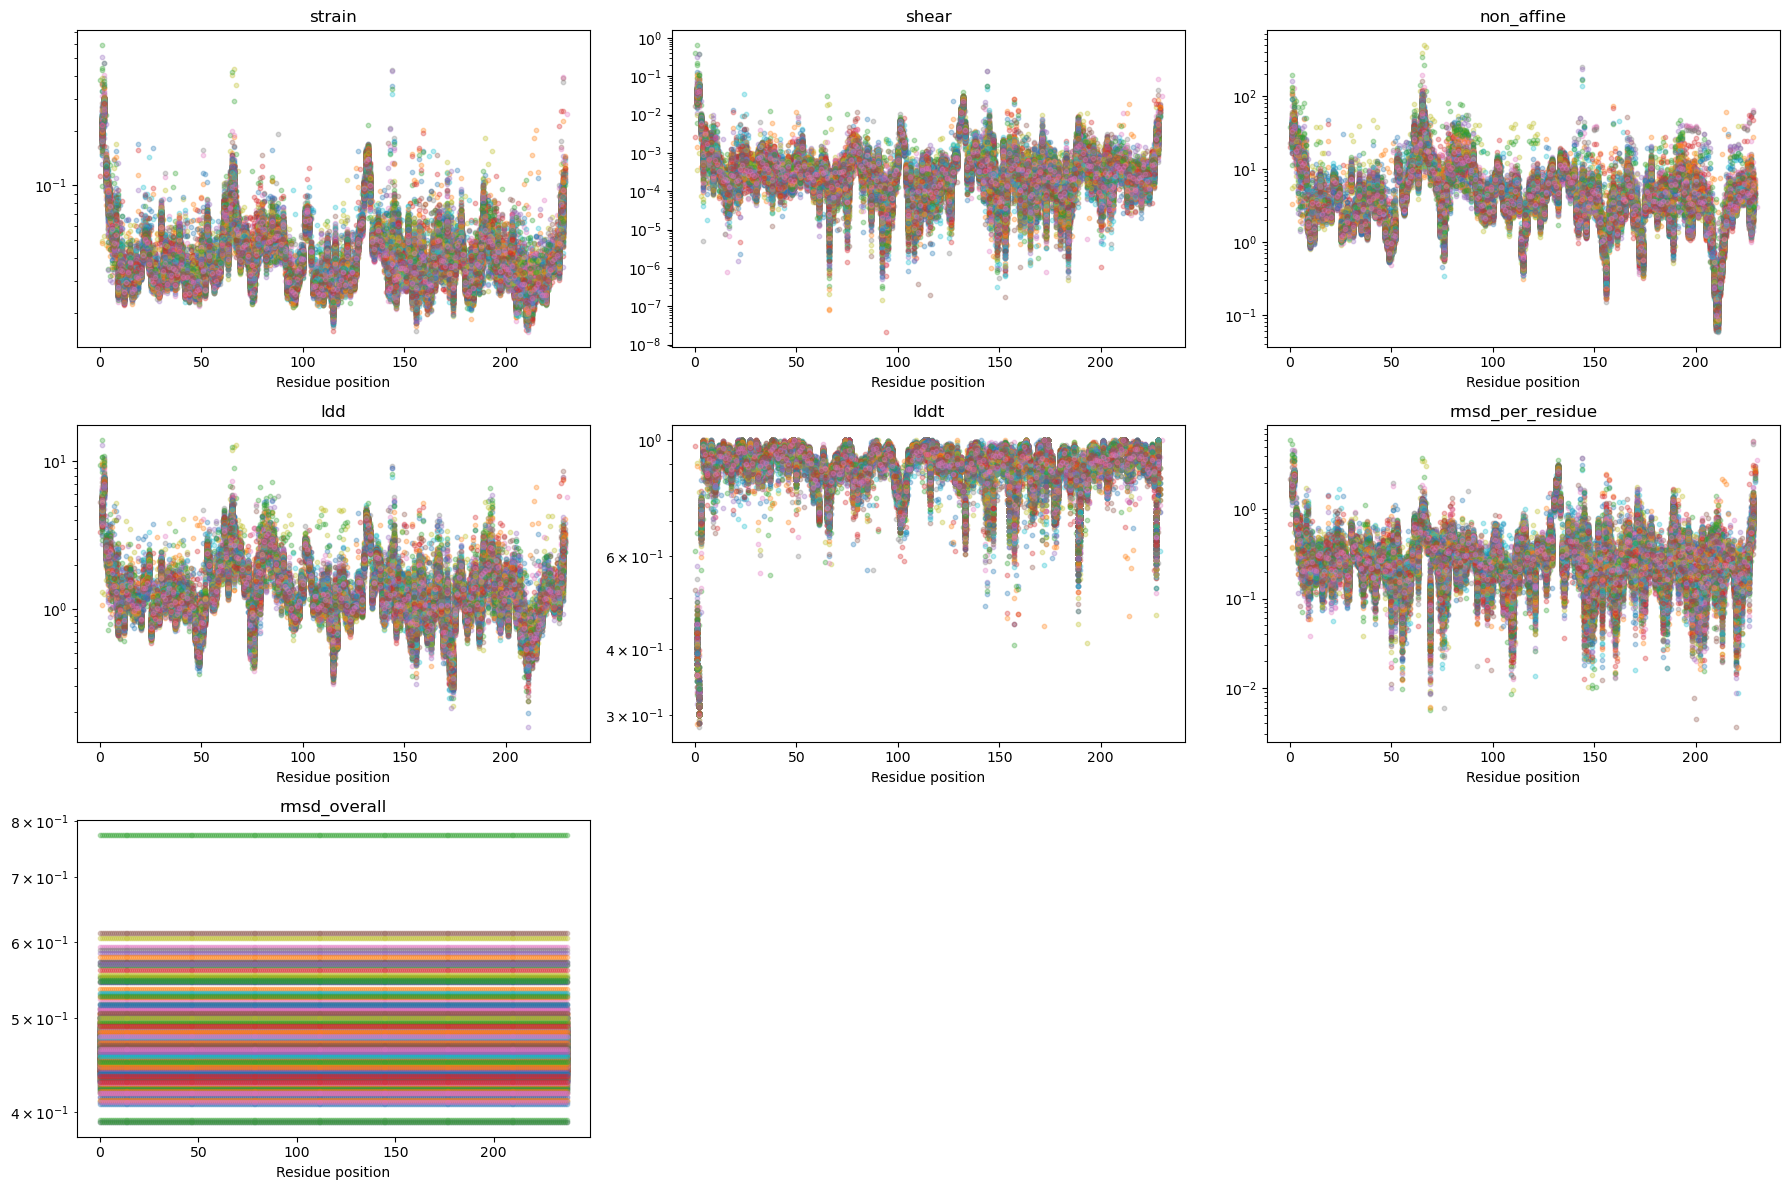

In [27]:
plot_metrics(strain_t[..., 1:], legend[1:], ncols=3)

In [28]:
from typing import List, Sequence, Union, Dict, Tuple, Optional
from collections.abc import Iterable

def _is_iterable_of_int(x) -> bool:
    return isinstance(x, Iterable) and not isinstance(x, (str, bytes)) and all(isinstance(i, (int, np.integer)) for i in x)

def build_sequence_features(
    metrics: np.ndarray,                 # (n_files, n_residues, n_features)
    legend: List[str],                   # names for last axis
    mut_positions: Optional[Sequence[Union[int, Sequence[int]]]] = None,  # per-file int or list[int]
    window: int = 3,                     # +/- residues around mutation(s)
    add_quantiles: Tuple[float, ...] = (0.1, 0.25, 0.5, 0.75, 0.9),
    thresholds: Optional[Dict[str, Sequence[float]]] = None,  # per-metric thresholds; if None auto
) -> pd.DataFrame:
    """
    Returns a DataFrame with one row per sequence (file) and many columns (features).
    """
    assert metrics.ndim == 3, "metrics must be (n_files, n_residues, n_features)"
    n_files, n_res, n_feat = metrics.shape
    assert len(legend) == n_feat, "legend length must match metrics' last dim"

    # Precompute pooled thresholds if not provided
    auto_thresh: Dict[str, List[float]] = {}
    if thresholds is None:
        for k, name in enumerate(legend):
            pooled = metrics[:, :, k].ravel()
            pooled = pooled[np.isfinite(pooled)]
            if pooled.size == 0:
                auto_thresh[name] = []
                continue
            # use deciles-ish cut points
            qs = np.quantile(pooled, [0.25, 0.5, 0.75])
            auto_thresh[name] = list(qs)
    else:
        for name in legend:
            auto_thresh[name] = list(thresholds.get(name, []))

    # normalize mut_positions into list[list[int]] or None
    mut_lists: Optional[List[List[int]]] = None
    if mut_positions is not None:
        mut_lists = []
        for mp in mut_positions:
            if isinstance(mp, (int, np.integer)):
                mut_lists.append([int(mp)])
            elif _is_iterable_of_int(mp):
                mut_lists.append([int(i) for i in mp])
            elif mp is None:
                mut_lists.append([])
            else:
                raise ValueError("Each mut_positions item must be int, list[int], or None")

    rows = []
    for i in range(n_files):
        row = {}
        for k, name in enumerate(legend):
            v = metrics[i, :, k]
            v = v[np.isfinite(v)]
            if v.size == 0:
                # fill NaNs if nothing is finite
                row[f"{name}__mean"] = np.nan
                row[f"{name}__std"] = np.nan
                row[f"{name}__min"] = np.nan
                row[f"{name}__max"] = np.nan
                for q in add_quantiles:
                    row[f"{name}__q{int(100*q)}"] = np.nan
                continue

            # global stats
            row[f"{name}__mean"] = float(np.mean(v))
            row[f"{name}__std"]  = float(np.std(v))
            row[f"{name}__min"]  = float(np.min(v))
            row[f"{name}__max"]  = float(np.max(v))
            for q in add_quantiles:
                row[f"{name}__q{int(100*q)}"] = float(np.quantile(v, q))

            # proportions above thresholds
            for t in auto_thresh.get(name, []):
                row[f"{name}__prop_ge_{t:.3g}"] = float(np.mean(v >= t))

            # local features at mutation site(s)
            if mut_lists is not None:
                idxs = [j for j in mut_lists[i] if 0 <= j < n_res]
                if idxs:
                    vals_at_mut = metrics[i, idxs, k]
                    vals_at_mut = vals_at_mut[np.isfinite(vals_at_mut)]
                    if vals_at_mut.size:
                        row[f"{name}__mut_mean"] = float(np.mean(vals_at_mut))
                        row[f"{name}__mut_max"]  = float(np.max(vals_at_mut))
                        row[f"{name}__mut_min"]  = float(np.min(vals_at_mut))
                    else:
                        row[f"{name}__mut_mean"] = np.nan
                        row[f"{name}__mut_max"]  = np.nan
                        row[f"{name}__mut_min"]  = np.nan

                    # windowed neighborhood around mutation(s)
                    win_vals = []
                    for j in idxs:
                        lo = max(0, j - window)
                        hi = min(n_res, j + window + 1)
                        vv = metrics[i, lo:hi, k]
                        vv = vv[np.isfinite(vv)]
                        if vv.size:
                            win_vals.append(vv)
                    if win_vals:
                        w = np.concatenate(win_vals)
                        row[f"{name}__win{window}_mean"] = float(np.mean(w))
                        row[f"{name}__win{window}_std"]  = float(np.std(w))
                        row[f"{name}__win{window}_max"]  = float(np.max(w))
                        row[f"{name}__win{window}_min"]  = float(np.min(w))
                    else:
                        row[f"{name}__win{window}_mean"] = np.nan
                        row[f"{name}__win{window}_std"]  = np.nan
                        row[f"{name}__win{window}_max"]  = np.nan
                        row[f"{name}__win{window}_min"]  = np.nan

        rows.append(row)

    return pd.DataFrame(rows)


In [30]:
feat_df = build_sequence_features(strain_t, legend, mut_positions=None, window=3)

# Add target
feat_df["brightness"] = filtered_df["medianBrightness"].values

In [31]:
feat_df.head()

,mut_dist__mean,mut_dist__std,mut_dist__min,mut_dist__max,mut_dist__q10,mut_dist__q25,mut_dist__q50,mut_dist__q75,mut_dist__q90,mut_dist__prop_ge_15.6,...,rmsd_overall__max,rmsd_overall__q10,rmsd_overall__q25,rmsd_overall__q50,rmsd_overall__q75,rmsd_overall__q90,rmsd_overall__prop_ge_0.45,rmsd_overall__prop_ge_0.462,rmsd_overall__prop_ge_0.475,brightness
0,18.242045,6.025717,0.0,32.881000,9.874034,14.421452,18.957805,22.261626,25.526743,0.701754,...,0.453114,0.453114,0.453114,0.453114,0.453114,0.453114,1.0,0.0,0.0,3.708478
1,21.436751,8.290041,0.0,39.742529,10.437435,15.644269,21.544397,27.127074,32.258217,0.750000,...,0.475452,0.475452,0.475452,0.475452,0.475452,0.475452,1.0,1.0,1.0,3.872970
2,20.896600,8.544436,0.0,40.007782,9.809152,14.541442,20.577780,27.569086,32.834500,0.706140,...,0.472219,0.472219,0.472219,0.472219,0.472219,0.472219,1.0,1.0,0.0,3.137392
3,20.582799,6.805647,0.0,35.989965,11.329988,16.265005,21.308128,25.667780,28.752704,0.771930,...,0.459802,0.459802,0.459802,0.459802,0.459802,0.459802,1.0,0.0,0.0,3.739811
4,21.749300,8.514674,0.0,41.888058,10.663917,15.432528,21.961944,27.783171,33.433189,0.741228,...,0.428298,0.428298,0.428298,0.428298,0.428298,0.428298,0.0,0.0,0.0,3.547796


In [32]:
from scipy.stats import spearmanr
corrs = {}
y = feat_df["brightness"].values
for col in feat_df.columns.drop("brightness"):
    x = feat_df[col].values
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() > 3:
        r, p = spearmanr(x[mask], y[mask])
        corrs[col] = (r, p)
corr_rank = pd.DataFrame(corrs, index=["spearman_r","pval"]).T.sort_values("spearman_r", ascending=False)

/tmp/ipykernel_1113311/2194548359.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = spearmanr(x[mask], y[mask])


In [33]:
corr_rank

,spearman_r,pval
non_affine__q50,0.112729,0.000362
strain__mean,0.111966,0.000397
non_affine__prop_ge_3.98,0.111096,0.000441
strain__q90,0.110699,0.000462
non_affine__q25,0.110638,0.000466
...,...,...
lddt__mean,-0.065262,0.039373
lddt__q75,-0.066442,0.035938
lddt__prop_ge_0.949,-0.067436,0.033248
mut_dist__min,NaN,NaN


In [21]:
brightness = filtered_df["medianBrightness"].values

# Option 1: Vectorized with numpy.corrcoef (fast)
corrs = np.array([
    np.corrcoef(es_new[:, i], brightness)[0, 1]
    for i in range(es_new.shape[1])
])

### Effective strain analyssi over whole data

In [8]:
brightness = filtered_df["medianBrightness"].values

# Option 1: Vectorized with numpy.corrcoef (fast)
corrs = np.array([
    np.corrcoef(strain_t[:, i], brightness)[0, 1]
    for i in range(strain_t.shape[1])
])

In [9]:
corrs.argmin()

np.int64(190)

In [10]:
corr_df = pd.DataFrame({
    "residue": np.arange(strain_t.shape[1]),
    "correlation": corrs
})

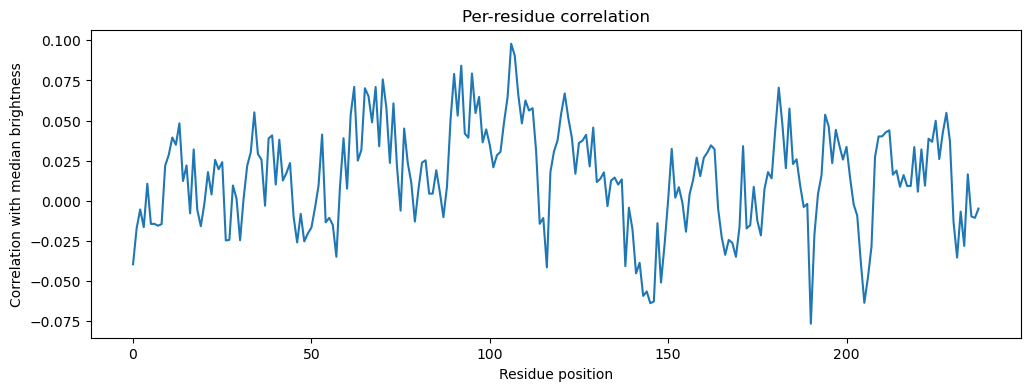

In [11]:
plt.figure(figsize=(12,4))
plt.plot(corr_df["residue"], corr_df["correlation"])
plt.xlabel("Residue position")
plt.ylabel("Correlation with median brightness")
plt.title("Per-residue correlation")
plt.show()


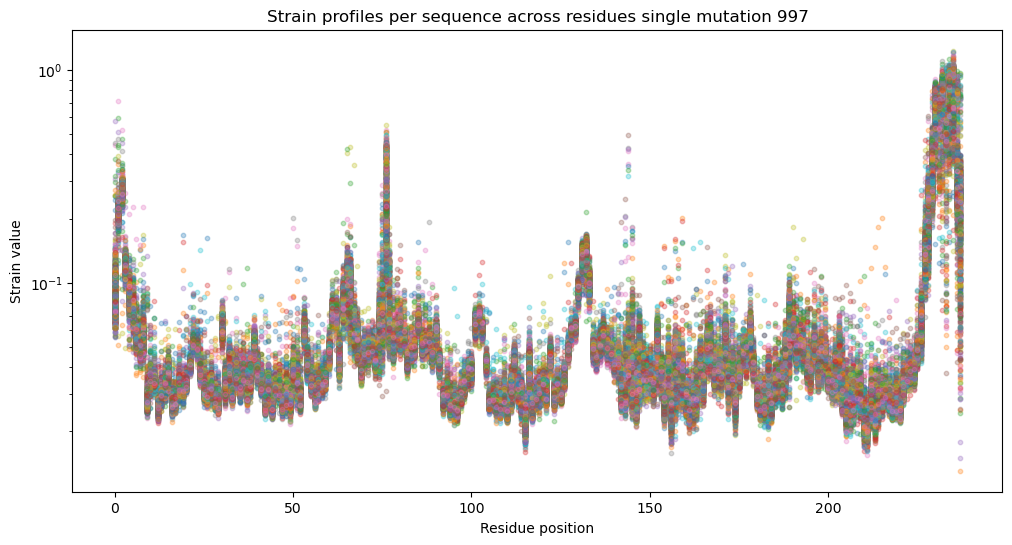

In [23]:
plt.figure(figsize=(12,6))
for i in range(strain_t.shape[0]):   # loop over sequences
    plt.scatter(range(strain_t.shape[1]), strain_t[i, :], alpha=0.3, s=10)

plt.xlabel("Residue position")
plt.ylabel("Strain value")
plt.yscale("log")
plt.title(f"Strain profiles per sequence across residues single mutation {len(strain_t)}")
plt.show()

### Effective strain analysis over data with n number of mutations

In [43]:
gfp_dataset = pd.read_csv(tsv_path, sep='\t')
gfp_dataset["num_mut"] = gfp_dataset["aaMutations"].apply(get_numb_mut)
seq_nums = extract_seq_numbers(files_id)
filtered_df = gfp_dataset.loc[gfp_dataset.index.isin(seq_nums)]

In [55]:
len(gfp_dataset["num_mut"]==1)

54025

In [52]:
# mask = (filtered_df["num_mut"] == 1) | (filtered_df["num_mut"] == 2)
mask = filtered_df["num_mut"] == 1
idx = np.where(mask)[0]
filtered_df = filtered_df.iloc[idx]
strain_selected = strain_t[idx, :]

In [53]:
len(filtered_df)

41

In [47]:
brightness = filtered_df["medianBrightness"].values

# Option 1: Vectorized with numpy.corrcoef (fast)
corrs = np.array([
    np.corrcoef(strain_selected[:, i], brightness)[0, 1]
    for i in range(strain_selected.shape[1])
])

In [48]:
corr_df = pd.DataFrame({
    "residue": np.arange(strain_selected.shape[1]),
    "correlation": corrs
})

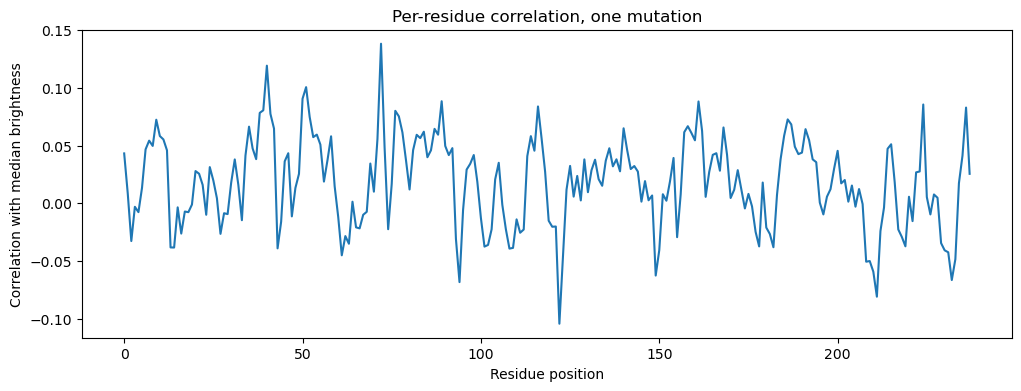

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(corr_df["residue"], corr_df["correlation"])
plt.xlabel("Residue position")
plt.ylabel("Correlation with median brightness")
plt.title("Per-residue correlation, one mutation")
plt.show()

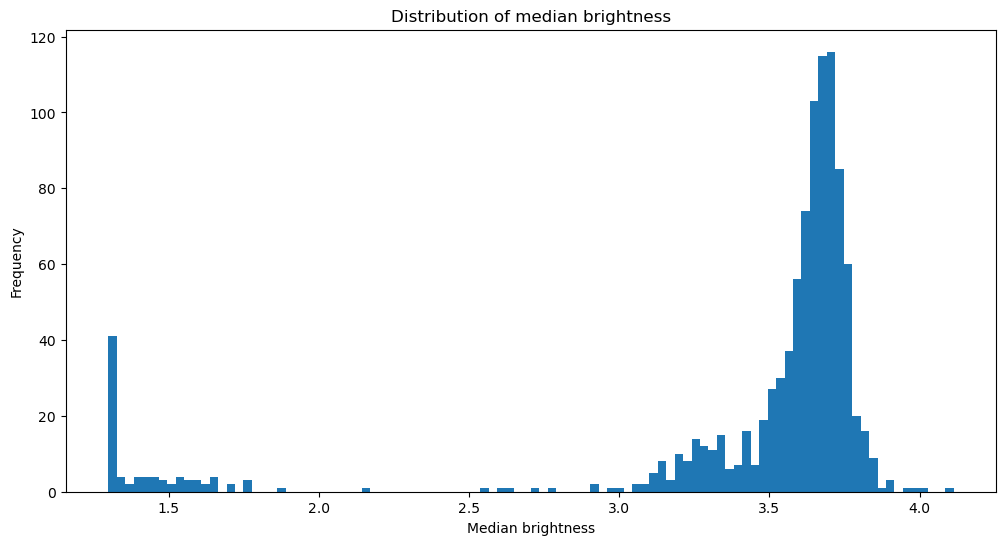

In [19]:
# distirbution of brigthness 
plt.figure(figsize=(12,6))
plt.hist(filtered_df["medianBrightness"].values, bins=100)
plt.xlabel("Median brightness")
plt.ylabel("Frequency")
plt.title("Distribution of median brightness")
plt.show()

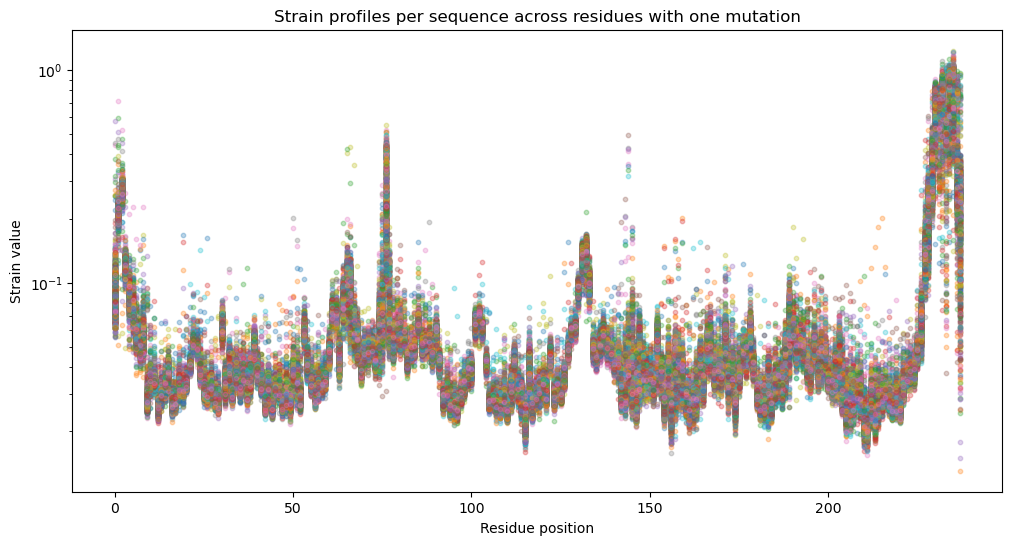

In [21]:
plt.figure(figsize=(12,6))
for i in range(strain_t.shape[0]):   # loop over sequences
    plt.scatter(range(strain_t.shape[1]), strain_t[i, :], alpha=0.3, s=10)

plt.xlabel("Residue position")
plt.ylabel("Strain value")
plt.yscale("log")
plt.title("Strain profiles per sequence across residues with one mutation")
plt.show()

## Extra stuff

In [13]:
import scipy

In [14]:
correlation_pos = []
for i in tqdm(range(final_array.shape[1])):
    correlation_pos.append(scipy.stats.pearsonr(final_array[:, i, 1], filtered_df['medianBrightness'].values))


100%|██████████| 238/238 [00:00<00:00, 551.74it/s]


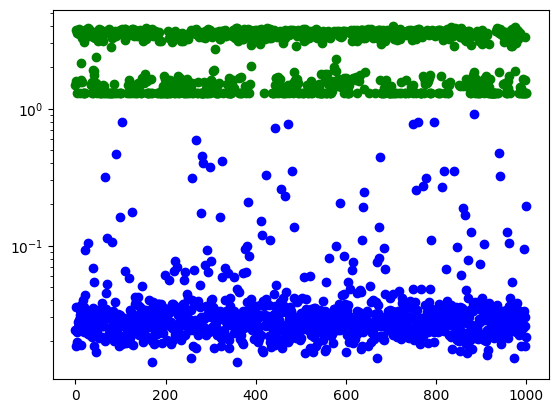

In [15]:
from turtle import color


plt.figure()
plt.scatter(y=filtered_df['medianBrightness'].values, x=np.arange(filtered_df['medianBrightness'].values.shape[0]), color='g')
plt.scatter(y=final_array[:, 57, 1], x=np.arange(final_array[:, 57, 1].shape[0]), color='b')
plt.yscale('log')
plt.show()

In [59]:
import scipy

In [62]:
scipy.stats.pearsonr(final_array[:, 57, 1], filtered_df['medianBrightness'].values)

PearsonRResult(statistic=np.float64(0.03381930920638052), pvalue=np.float64(0.28484485015629946))

In [16]:
corrs = np.stack(correlation_pos, 0)

In [17]:
np.argmax(corrs, 0)

array([74, 37])

In [21]:
final_array[:, 57, 1].argmax()

np.int64(884)

In [18]:
corrs[74]

array([0.06206207, 0.04953265])